In [1]:
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import nb

%matplotlib inline
%load_ext autoreload
%autoreload 2

http://cs229.stanford.edu/ps/ps2/ps2.pdf

Let's start with a simple example to understand Multinomial Naive Bayes.

| Text | Tag   |
|:------|:------:|
| investors! free for qualified investors &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Spam |
| discount prices for game investors | Spam |
| lets grab a coffee | Not spam |
| investors get a free discount | Spam |
| our coffee game is a game for | Not spam |

Then our vocabulary, denoted by $V$, with an extra column for the number of times used, is

| Index | Word | Times used   |
|:------:|:------:|:------:|
| &nbsp; 0 &nbsp; |&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; a &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | 3 |
| 1 | coffee | 2 |
| 2 | discount | 2 |
| 3 | for | 3 |
| 4 | free | 2 |
| 5 | game | 3 |
| 6 | get | 1 |
| 7 | grab | 1 |
| 8 | investors | 4 |
| 9 | is | 1 |
| 10 | lets | 1 |
| 11 | our | 1 |
| 12 | prices | 1 |
| 13 | qualified | 1 |

But it's easier to code this up:

In [2]:
train_phrases = ['investors free for qualified investors',
                'discount prices for game investors',
                'lets grab a coffee',
                'investors get a free discount',
                'our coffee game is a game for']

def make_vocab(train_phrases):
    all_words = []
    for phrase in train_phrases:
        word_list = phrase.split()
        for w in word_list: all_words.append(w)
    auw = list(set(all_words)) # removes dups
    auw.sort()
    return {i:w for i,w in zip(range(len(auw)), auw)}

Voc1 = make_vocab(train_phrases)
print("Voc1={0}\n".format(Voc1))

def get_V_key(value, V):
    for key in V:
        if V[key] == value: return key
    return None

def parse_phrases(phrases, V):
    X = []
    for phrase in phrases:
        js = [get_V_key(word, V) for word in phrase.split()]
        d = {j:js.count(j) for j in js}
        x = np.zeros(len(V))
        for k, v in d.items():
            x[k] = v
        X.append(x)
    return np.array(X, dtype=int)

Xtr_1 = parse_phrases(train_phrases, Voc1)

ytr_1 = np.array([1,1,0,1,0]) # 1 denotes Spam, 0 denotes non-Spam

Xtr_1s, Xtr_1n = Xtr_1[ytr_1==1], Xtr_1[ytr_1==0]

print("Xtr_1=\n{}".format(Xtr_1))

print("\nOccurrence count=")

print("%-4s %-12s %-4s %-4s %4s" % ("Ind", "Word", "Total", "Spam", "Not"))
print("---------------------------------")
for key, value in Voc1.items():
    tc, sc, nc = np.sum(Xtr_1[:,key]), np.sum(Xtr_1s[:,key]), np.sum(Xtr_1n[:,key])
    print("%-4.0f %-12s %4.0f %4.0f %4.0f" % (key, value, tc, sc, nc))

cnt_spam_words, cnt_ns_words = np.sum(Xtr_1s), np.sum(Xtr_1n)
print("\ncnt_spam_words={}  cnt_ns_words={}".format(cnt_spam_words, cnt_ns_words))

Voc1={0: 'a', 1: 'coffee', 2: 'discount', 3: 'for', 4: 'free', 5: 'game', 6: 'get', 7: 'grab', 8: 'investors', 9: 'is', 10: 'lets', 11: 'our', 12: 'prices', 13: 'qualified'}

Xtr_1=
[[0 0 0 1 1 0 0 0 2 0 0 0 0 1]
 [0 0 1 1 0 1 0 0 1 0 0 0 1 0]
 [1 1 0 0 0 0 0 1 0 0 1 0 0 0]
 [1 0 1 0 1 0 1 0 1 0 0 0 0 0]
 [1 1 0 1 0 2 0 0 0 1 0 1 0 0]]

Occurrence count=
Ind  Word         Total Spam  Not
---------------------------------
0    a               3    1    2
1    coffee          2    0    2
2    discount        2    2    0
3    for             3    2    1
4    free            2    2    0
5    game            3    1    2
6    get             1    1    0
7    grab            1    0    1
8    investors       4    4    0
9    is              1    0    1
10   lets            1    0    1
11   our             1    0    1
12   prices          1    1    0
13   qualified       1    1    0

cnt_spam_words=15  cnt_ns_words=11


### Naive Bayes - Multinomial

Note let's suppose we get a new phrase "discount for coffee investors" and we wish to classify it as spam or not. Using Bayes, we compute

$$\begin{align*}
P(\text{Spam}\mid \text{discount for coffee investors})=\frac{P(\text{discount for coffee investors}\mid\text{Spam})P(\text{Spam})}{P(\text{discount for coffee investors})}
\end{align*}$$

and

$$\begin{align*}
P(\text{Not-Spam}\mid \text{discount for coffee investors})=\frac{P(\text{discount for coffee investors}\mid\text{Not-Spam})P(\text{Not-Spam})}{P(\text{discount for coffee investors})}
\end{align*}$$

Then we pick the larger of the two. But we can discard the denominator because it is the same in both cases. Discarding this, we still pick the larger of the two:

$$\begin{align*}
P(\text{Spam}\mid \text{discount for coffee investors})\propto P(\text{discount for coffee investors}\mid\text{Spam})P(\text{Spam})\tag{SE.1.1}
\end{align*}$$

and

$$\begin{align*}
P(\text{Not-Spam}\mid \text{discount for coffee investors})\propto P(\text{discount for coffee investors}\mid\text{Not-Spam})P(\text{Not-Spam})\tag{SE.1.2}
\end{align*}$$

Estimating the prior class probabilities is easy. Define

$$\begin{align*}
\phi_c\equiv\frac{\text{number of occurences of class }c\text{ in training data}}{\text{number of observations in training data}}\approx P(c)\tag{SE.1.3}
\end{align*}$$

so that $\phi_c$ denotes the estimated prior probability of class $c$. Then

$$\begin{align*}
\phi_{Spam}=\frac{3}{5}\quad\quad\quad \phi_{Not-Spam}=\frac{2}{5}
\end{align*}$$

But we have a problem. The phrase "discount for coffee investors" doesn't appear in our training data so the probabilities in SE.1.1 and SE.1.2 will both be zero. To circumvent this, we make the Naive Bayes Assumption: the words in each phrase are conditionally independent given the classfication. That is, we assume

$$\begin{align*}
P(\text{discount for coffee investors}\mid c)=P(\text{discount}\mid c)P(\text{for}\mid c)P(\text{coffee}\mid c)P(\text{investors}\mid c)\tag{SE.1.4}
\end{align*}$$

Note that $P(\text{for}\mid c)$ denotes the probability of word "for" appearing a single time. If "for" were to appear twice in a phrase, then we would have

$$\begin{align*}
P(\text{discount for coffee for investors}\mid c) &=P(\text{discount}\mid c)P(\text{for}\mid c)P(\text{coffee}\mid c)P(\text{for}\mid c)P(\text{investors}\mid c)\\
     &=P(\text{discount}\mid c)P(\text{for}\mid c)^{2}P(\text{coffee}\mid c)P(\text{investors}\mid c)\\
\end{align*}$$

Similarly, if "for" were to appear three times in a phrase, then we would have

$$\begin{align*}
P(\text{discount for coffee for investors for}\mid c) &=P(\text{discount}\mid c)P(\text{for}\mid c)P(\text{coffee}\mid c)P(\text{for}\mid c)P(\text{investors}\mid c)P(\text{for}\mid c)\\
     &=P(\text{discount}\mid c)P(\text{for}\mid c)^{3}P(\text{coffee}\mid c)P(\text{investors}\mid c)\\
\end{align*}$$

Let $P(w_j\mid c)$ denote the probability that the word with index $j$ appears once in a phrase classified as $c$. And let $N(w,c)$ denote the number of occurences of word $w$ for observations classified as $c$. We can estimate each of the probabilities on the right side of SE.1.4. Define

$$\begin{align*}
\phi_{j\mid y=c}\equiv\frac{N(w_j,c)}{\sum_{w\in V}N(w,c)}\approx P(w_j\mid c)\tag{SE.1.5}
\end{align*}$$

so that $\phi_{j\mid y=c}$ denotes the estimated conditional probability that the word $w_j$ appears once in an observation classified as $c$. For example:

$$\begin{align*}
P(\text{investors}\mid\text{Not-Spam})\approx\phi_{8\mid y=0}=\frac{N(w_8,0)}{\sum_{w\in V}N(w,0)}=\frac{0}{11}=0
\end{align*}$$

$$\begin{align*}
P(\text{investors}\mid\text{Spam})\approx\phi_{8\mid y=1}=\frac{N(w_8,1)}{\sum_{w\in V}N(w,1)}=\frac{4}{15}
\end{align*}$$

$$\begin{align*}
P(\text{coffee}\mid\text{Not-Spam})\approx\phi_{1\mid y=0}=\frac{N(w_1,0)}{\sum_{w\in V}N(w,0)}=\frac{2}{11}
\end{align*}$$

$$\begin{align*}
P(\text{coffee}\mid\text{Spam})\approx\phi_{1\mid y=1}=\frac{N(w_1,1)}{\sum_{w\in V}N(w,1)}=\frac{0}{15}=0
\end{align*}$$

$$\begin{align*}
P(\text{game}\mid\text{Not-Spam})\approx\phi_{5\mid y=0}=\frac{N(w_5,0)}{\sum_{w\in V}N(w,0)}=\frac{2}{11}
\end{align*}$$

$$\begin{align*}
P(\text{game}\mid\text{Spam})\approx\phi_{5\mid y=1}=\frac{N(w_5,1)}{\sum_{w\in V}N(w,1)}=\frac{1}{15}
\end{align*}$$

Now we have another problem. The word "coffee" doesn't appear in any training observations that are classified as spam. Hence $\phi_{1\mid y=1}=0\approx P(\text{coffee}\mid\text{Spam})$. This is a problem because in equation SE.1.4, this would give $P(\text{discount for coffee investors}\mid \text{Spam})=0$. But we would obviously like to classify the phrase "discount for coffee investors" as spam.

To get around this, we use Laplace Smoothing. We add $1$ to every count $N(w,c)$. Then SE.1.5 becomes

$$\begin{align*}
P(w_j\mid c)\approx\phi_{j\mid y=c}=\frac{N(w_j,c)+1}{\sum_{w\in V}\big(N(w,c)+1\big)}=\frac{N(w_j,c)+1}{\sum_{w\in V}N(w,c)+\lvert V\rvert}\tag{SE.1.6}
\end{align*}$$

Besides helping us avoid zero probability estimates, Laplace Smoothing is intuitive and realistic. That is, it is not impossible that the word "coffee" will appear in test (or real-world) spam emails, simply because it didn't appear in our spam-labeled training data.

Then our examples become

$$\begin{align*}
P(\text{investors}\mid\text{Not-Spam})\approx\phi_{8\mid y=0}=\frac{0+1}{11+14}=\frac{1}{25}
\end{align*}$$

$$\begin{align*}
P(\text{investors}\mid\text{Spam})\approx\phi_{8\mid y=1}=\frac{4+1}{15+14}=\frac{5}{29}
\end{align*}$$

$$\begin{align*}
P(\text{coffee}\mid\text{Not-Spam})\approx\phi_{1\mid y=0}=\frac{2+1}{11+14}=\frac{3}{25}
\end{align*}$$

$$\begin{align*}
P(\text{coffee}\mid\text{Spam})\approx\phi_{1\mid y=1}=\frac{0+1}{15+14}=\frac{1}{29}
\end{align*}$$

$$\begin{align*}
P(\text{game}\mid\text{Not-Spam})\approx\phi_{5\mid y=0}=\frac{2+1}{11+14}=\frac{3}{25}
\end{align*}$$

$$\begin{align*}
P(\text{game}\mid\text{Spam})\approx\phi_{5\mid y=1}=\frac{1+1}{15+14}=\frac{2}{29}
\end{align*}$$

Then our computations for SE.1.4 are

$$\begin{align*}
P(\text{discount for coffee investors}\mid\text{Spam}) &= P(\text{discount}\mid\text{Spam})P(\text{for}\mid \text{Spam})P(\text{coffee}\mid\text{Spam})P(\text{investors}\mid\text{Spam})\\\\
    &\approx \phi_{2\mid y=1}\phi_{3\mid y=1}\phi_{1\mid y=1}\phi_{8\mid y=1}
\end{align*}$$

and

$$\begin{align*}
P(\text{discount for coffee investors}\mid\text{Not-Spam}) &\approx \phi_{2\mid y=0}\phi_{3\mid y=0}\phi_{1\mid y=0}\phi_{8\mid y=0}
\end{align*}$$

Then we can compare

$$\begin{align*}
P(\text{Spam}\mid \text{discount for coffee investors})&\propto P(\text{discount for coffee investors}\mid\text{Spam})P(\text{Spam})\\\\
    &\approx \phi_{2\mid y=1}\phi_{3\mid y=1}\phi_{1\mid y=1}\phi_{8\mid y=1}\frac{3}{5}
\end{align*}$$

and

$$\begin{align*}
P(\text{Not-Spam}\mid \text{discount for coffee investors})&\propto P(\text{discount for coffee investors}\mid\text{Not-Spam})P(\text{Not-Spam})\\\\
    &\approx \phi_{2\mid y=0}\phi_{3\mid y=0}\phi_{1\mid y=0}\phi_{8\mid y=0}\frac{2}{5}
\end{align*}$$

But of course this is easier with code:

In [3]:
Njc = lambda j, Xc: np.sum(Xc[:,j])

phijc = lambda j, Xc, V: (Njc(j, Xc) + 1)/(np.sum([Njc(i, Xc) for i in range(len(V))]) + len(V))

prob_sp_dfci = phijc(2,Xtr_1s,Voc1) * phijc(3,Xtr_1s,Voc1) * phijc(1,Xtr_1s,Voc1) * phijc(8,Xtr_1s,Voc1) * 3/5
prob_ns_dfci = phijc(2,Xtr_1n,Voc1) * phijc(3,Xtr_1n,Voc1) * phijc(1,Xtr_1n,Voc1) * phijc(8,Xtr_1n,Voc1) * 2/5
print("Spam={:.8f}  Not={:.8f} \"discount for coffee investors\"".format(prob_sp_dfci, prob_ns_dfci))

prob_sp_dfci = phijc(2,Xtr_1s,Voc1) * np.power(phijc(3,Xtr_1s,Voc1), 2) * phijc(1,Xtr_1s,Voc1) * phijc(8,Xtr_1s,Voc1) * 3/5
prob_ns_dfci = phijc(2,Xtr_1n,Voc1) * np.power(phijc(3,Xtr_1n,Voc1), 2) * phijc(1,Xtr_1n,Voc1) * phijc(8,Xtr_1n,Voc1) * 2/5
print("Spam={:.8f}  Not={:.8f} \"discount for coffee for investors\"".format(prob_sp_dfci, prob_ns_dfci))

# to check more of these, it will be easier to use this approach:

def compute_probs(phrase, X1, X0, y, V):
    js = [get_V_key(word, V) for word in phrase.split()]
    prob_sp = np.sum(y==1) / y.shape[0] * np.prod([phijc(j, X1, V) for j in js])
    prob_ns = np.sum(y==0) / y.shape[0] * np.prod([phijc(j, X0, V) for j in js])
    return np.array([prob_sp, prob_ns])

def classify(phrase, X, y, V):
    X1, X0 = X[y==1], X[y==0]
    cp = compute_probs(phrase, X1, X0, y, V)
    ratio = cp[1] / cp[0] if cp[1] >= cp[0] else cp[0] / cp[1]
    label = "SPAM" if cp[0] >= cp[1] else "NOT"
    print("Spam={:.8f}  Not={:.8f}  ratio={:.2f}  \"{}\"  class={}".format(cp[0], cp[1], ratio, phrase, label))

test_phrases = ['discount for coffee investors',
    'discount for coffee for investors',
    'a coffee is coffee',
    'a coffee is free',
    'investors coffee is free',
    'investors coffee is discount',
    'investors coffee is game',
    'investors coffee get game',
    'investors get prices free for qualified investors',
    'our coffee grab is lets coffee']

start = time.time()
for phr in test_phrases: classify(phr, Xtr_1, ytr_1, Voc1)
end = time.time()
print("TIME={} seconds".format(end-start))
    
# but we can vectorize this

def train_1(X, y, V):
    X1, X0 = X[y==1], X[y==0]
    phi_js_yeq1 = (np.sum(X1, axis=0) + 1) / (np.sum(X1) + len(V))
    phi_js_yeq0 = (np.sum(X0, axis=0) + 1) / (np.sum(X0) + len(V))
    phi_yeq1 = np.sum(y==1) / y.shape[0]
    phi_yeq0 = np.sum(y==0) / y.shape[0]
    return phi_js_yeq1, phi_js_yeq0, phi_yeq1, phi_yeq0

def predict_1(phi_js_yeq1, phi_js_yeq0, phi_yeq1, phi_yeq0, V, test_phrases):
    Xtest = parse_phrases(test_phrases, V)
    pX1 = np.power(phi_js_yeq1, Xtest)
    pX0 = np.power(phi_js_yeq0, Xtest)
    s1 = phi_yeq1 * np.prod(pX1, axis=1)
    s0 = phi_yeq0 * np.prod(pX0, axis=1)
    rs = s1/s0
    rs[rs<1] = 1./rs[rs<1]
    return s1, s0, rs

def train_and_predict_1(X, y, V, test_phrases):
    phi_js_yeq1, phi_js_yeq0, phi_yeq1, phi_yeq0 = train_1(X, y, V)
    return predict_1(phi_js_yeq1, phi_js_yeq0, phi_yeq1, phi_yeq0, V, test_phrases)

np.set_printoptions(suppress=True)
start = time.time()
s1, s0, rs = train_and_predict_1(Xtr_1, ytr_1, Voc1, test_phrases)
print("s1={}\ns0={}\nrs={}".format(s1.round(8), s0.round(8), rs))
end = time.time()
print("TIME={} seconds".format(end-start))
    

Spam=0.00003817  Not=0.00000614 "discount for coffee investors"
Spam=0.00000395  Not=0.00000049 "discount for coffee for investors"
Spam=0.00003817  Not=0.00000614  ratio=6.21  "discount for coffee investors"  class=SPAM
Spam=0.00000395  Not=0.00000049  ratio=8.03  "discount for coffee for investors"  class=SPAM
Spam=0.00000170  Not=0.00005530  ratio=32.59  "a coffee is coffee"  class=NOT
Spam=0.00000509  Not=0.00001843  ratio=3.62  "a coffee is free"  class=NOT
Spam=0.00001272  Not=0.00000614  ratio=2.07  "investors coffee is free"  class=SPAM
Spam=0.00001272  Not=0.00000614  ratio=2.07  "investors coffee is discount"  class=SPAM
Spam=0.00000848  Not=0.00001843  ratio=2.17  "investors coffee is game"  class=NOT
Spam=0.00001697  Not=0.00000922  ratio=1.84  "investors coffee get game"  class=SPAM
Spam=0.00000006  Not=0.00000000  ratio=477.67  "investors get prices free for qualified investors"  class=SPAM
Spam=0.00000000  Not=0.00000024  ratio=233.89  "our coffee grab is lets coffee"  c

### Formalize Multinomial Estimations

Now let's formalize and clearly write out a few items from above. Recall SE.1.6:

$$\begin{align*}
\phi_{j\mid y=c}\equiv\frac{N(w_j,c)+1}{\sum_{w\in V}\big(N(w,c)+1\big)}=\frac{N(w_j,c)+1}{\sum_{w\in V}N(w,c)+\lvert V\rvert}\approx P(w_j\mid c)\tag{SE.1.6}
\end{align*}$$

where $N(w,c)$ denotes the number of occurences of word $w$ for observations classified as $c$. If we let $\phi_j\approx P(w_j)$ denote the estimated probability that word $j$ appears in the training data regardless of class, then

$$\begin{align*}
\phi_{j}\equiv\frac{\sum_{i=1}^{m}x_j^{(i)}}{\sum_{i=1}^{m}n_i}\approx P(w_j)\tag{SE.1.7}
\end{align*}$$

where

- $m$ is the number of training observations
- $x^{(i)}\in\mathbb{R}^n$ denotes the $i^{th}$ training observation
- $x_j^{(i)}$ denotes the $j^{th}$ element of the $i^{th}$ training observation
- $n_i$ denotes the number of words, aka __tokens__, in observation $i$.

In SE.1.7, the numerator is the count of all the times that word $j$ appears in all of the training observations. And the denominator is the count (including multiplicities) of all the words that appear in all of the training observations. So this estimate is intuitive.

With this in mind, we can rewrite SE.1.6 withOUT Laplace smoothing as

$$\begin{align*}
\phi_{j\mid y=c}=\frac{\sum_{i=1}^{m}\boldsymbol{1} \{y^{(i)} =c \}x_j^{(i)}}{\sum_{i=1}^{m}\boldsymbol{1} \{y^{(i)} =c \}n_i}\approx P(w_j\mid y=c)
\end{align*}$$

and with Laplace smoothing as

$$\begin{align*}
\phi_{j\mid y=c}=\frac{\sum_{i=1}^{m}\boldsymbol{1} \{y^{(i)} =c \}x_j^{(i)} + 1}{\sum_{i=1}^{m}\boldsymbol{1} \{y^{(i)} =c \}n_i + \lvert V \rvert}\approx P(w_j\mid y=c)
\end{align*}$$

Similarly recall SE.1.3:

$$\begin{align*}
\phi_c\equiv\frac{\text{number of occurences of class }c\text{ in training data}}{\text{number of observations in training data}}\approx P(c)\tag{SE.1.3}
\end{align*}$$

so that $\phi_c$ denotes the estimated prior probability of class $c$. The numerator equals $\sum_{i=1}^{m} \boldsymbol{1} \{ y^{(i)} = c \}$. And the denominator is $m$. Hence

$$\begin{align*}
\phi_c=\frac{\sum_{i=1}^{m} \boldsymbol{1} \{ y^{(i)} = c \}}{m}\approx P(c)
\end{align*}$$

But throughout this document, $y$ will take values in $\{0,1\}$. So we will define

$$\begin{align*}
\phi_y\equiv\frac{\sum_{i=1}^{m} \boldsymbol{1} \{ y^{(i)} = 1 \}}{m}\approx P(y=1)
\end{align*}$$

And when we want to denote the estimated prior $P(y=0)$, we will write $1-\phi_y$.

Hence our maximum likelihood estimates for Multinomial Naive Bayes can be written as

$$\begin{gather}
\phi_{j\mid y=1}\equiv\frac{\sum_{i=1}^{m}\boldsymbol{1} \{y^{(i)} =1 \}x_j^{(i)} + 1}{\sum_{i=1}^{m} \boldsymbol{1} \{ y^{(i)} = 1 \} n_i + \lvert V \rvert}=\hat{P}(w_j\mid y=1)\tag{SE.1.8} \\\\
\phi_{j\mid y=0}\equiv\frac{\sum_{i=1}^{m}\boldsymbol{1} \{y^{(i)} =0 \}x_j^{(i)} + 1}{\sum_{i=1}^{m} \boldsymbol{1} \{ y^{(i)} = 0 \} n_i + \lvert V \rvert}=\hat{P}(w_j\mid y=0)\tag{SE.1.9} \\\\
\phi_{y}\equiv\frac{\sum_{i=1}^{m} \boldsymbol{1} \{ y^{(i)} = 1 \}}{m}=\hat{P}(y=1)\tag{SE.1.10}
\end{gather}$$

where the hat $\hat{P}$ denotes the maximum likelihood estimate.
 
Since $\hat{P}(w_j\mid y=1)=\phi_{j\mid y=1}$ denotes the estimated probability of word $j$ appearing once, then the estimated probability that word $j$ appears $x_j$ number of times is

$$\begin{gather}
\hat{p}(x_j\mid y=1)=\prod_{k=1}^{x_j}\hat{P}(w_j\mid y=1)=\phi_{j\mid y=1}^{x_j}\tag{SE.1.11} \\\\
\end{gather}$$

### Vectorize Training

We wish to produce three things from training:

1. An array of the $\{\phi_{j\mid y=1}\}_{j=1}^{n}$
1. An array of the $\{\phi_{j\mid y=0}\}_{j=1}^{n}$
1. The number $\phi_y$

Let $X$ denote the training data matrix. Let $X_1$ denote the matrix of rows from $X$ such that the corresponding label is $y=1$, and similarly for $X_0$. From SE.1.8, we have

$$
\phi_{j\mid y=1}\equiv\frac{\sum_{i=1}^{m}\boldsymbol{1} \{y^{(i)} =1 \}x_j^{(i)} + 1}{\sum_{i=1}^{m} \boldsymbol{1} \{ y^{(i)} = 1 \} n_i + \lvert V \rvert}=\frac{\sum_{i=1}^{m_1}x_j^{(1,i)} + 1}{\sum_{i=1}^{m_1} n_{1,i} + \lvert V \rvert}
$$

where $m_1$ is the number of rows in matrix $X_1$, $x^{(1,i)}$ is the $i^{th}$ row in matrix $X_1$, and $n_{1,i}$ is the total number of words in the $i^{th}$ row of matrix $X_1$. But then $\sum_{i=1}^{m_1} n_{1,i}$ is total number of words in matrix $X_1$, denoted by $t_1$:

$$
\phi_{j\mid y=1}=\frac{\sum_{i=1}^{m_1}x_j^{(1,i)} + 1}{t_1 + \lvert V \rvert}
$$

In [4]:
def nb_train_ex(X, y):
    X1, X0 = X[y==1], X[y==0]
    vocab_size = X.shape[1]
    phi_js_yeq1 = (np.sum(X1, axis=0) + 1) / (np.sum(X1) + vocab_size)
    phi_js_yeq0 = (np.sum(X0, axis=0) + 1) / (np.sum(X0) + vocab_size)
    phi_y = np.sum(y==1) / y.shape[0]
    return phi_js_yeq1, phi_js_yeq0, phi_y

### Bernoulli NB Likelihood

Let's derive the log-likelihood in the case of Bernoulli Naive Bayes.

Let $y$ be a discrete random variable with values in $\{0,1\}$. Define $\phi_y\equiv \hat{P}(y=1)=\hat{p}_{y}(1)$.

Let $x=[x_1,...,x_n]^{T}$ be a discrete random vector with values in $\{0,1\}^{n}$, where $n$ is the number of features. That is, an observation from $x$ is a column vector in $\mathbb{R}^n$ whose elements are $0$ or $1$. Define

$$\begin{gather}
\phi_{j\mid y=1}\equiv\hat{P}(x_j=1\mid y=1)=\hat{p}_{x_j\mid y}(1\mid 1)\\\\
\phi_{j\mid y=0}\equiv\hat{P}(x_j=1\mid y=0)=\hat{p}_{x_j\mid y}(1\mid 0)
\end{gather}$$

Given a training set $\{x^{(i)},y^{(i)}\}_{i=1}^{m}$ where each $(x^{(i)},y^{(i)})$ is an independent observation from the joint random variable $(x,y)$, then the joint likelihood of the training data is

$$\begin{align*} 
\mathscr{L}\big(\phi_{j\mid y=1},\phi_{j\mid y=0},\phi_y;\{x^{(i)},y^{(i)}\}_{i=1}^{m}\big) &= P\big((x,y=x^{(1)},y^{(1)}),...,(x,y=x^{(m)},y^{(m)});\phi_{j|y=1},\phi_{j|y=0},\phi_y\big)\\\\
    &= \prod_{i=1}^{m}P\big(x,y=x^{(i)},y^{(i)};\phi_{j\mid y=1},\phi_{j\mid y=0},\phi_y\big)\tag{SCN.1}\\\\
    &= \prod_{i=1}^{m}p_{x,y}\big(x^{(i)},y^{(i)};\phi_{j\mid y=1},\phi_{j\mid y=0},\phi_y\big)\\\\
    &= \prod_{i=1}^{m}p_{x\mid y}\big(x^{(i)}\mid y^{(i)};\phi_{j\mid y=1},\phi_{j\mid y=0}\big)p_{y}\big(y^{(i)};\phi_y\big)\tag{SCN.2}\\\\
\end{align*}$$

SCN.1 holds from the assumption that observations are independent. SCN.2 holds from the definition of conditional probability. And the log-likelihood is

$$\begin{align*} 
\ell\big(\phi_{j\mid y=1},\phi_{j\mid y=0},\phi_y\big) &= \sum_{i=1}^m\mathrm{ln}\big[p_{x\mid y}(x^{(i)}\mid y^{(i)};\phi_{j\mid y=1},\phi_{j\mid y=0})\big]+ \sum_{i=1}^m\mathrm{ln}\big[p_{y}(y^{(i)};\phi_y)\big]\\\\
     &= \sum_{i=1}^m\mathrm{ln}\Big[\prod_{j=1}^{n}p_{x_{j}\mid y}(x_j^{(i)}\mid y^{(i)};\phi_{j\mid y=1},\phi_{j\mid y=0})\Big]+ \sum_{i=1}^m\mathrm{ln}\big[p_{y}(y^{(i)};\phi_y)\big]\tag{SCN.3}\\\\
     &= \sum_{i=1}^m\sum_{j=1}^{n}\mathrm{ln}\big[p_{x_{j}\mid y}(x_j^{(i)}\mid y^{(i)};\phi_{j\mid y=1},\phi_{j\mid y=0})\big]+ \sum_{i=1}^m\mathrm{ln}\big[p_{y}(y^{(i)};\phi_y)\big] \tag{SCN.4}\\\\
     &= \sum_{i=1}^m\sum_{j=1}^{n}\big\{\boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=1\}\mathrm{ln}(\phi_{j\mid y=1})+\boldsymbol{1}\{y^{(i)}=0\wedge x_j^{(i)}=1\}\mathrm{ln}(\phi_{j\mid y=0}) \\
     &+ \boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=0\}\mathrm{ln}(1-\phi_{j\mid y=1})+\boldsymbol{1}\{y^{(i)}=0\wedge x_j^{(i)}=0\}\mathrm{ln}(1-\phi_{j|y=0})\big\} \tag{SCN.5} \\
     &+ \sum_{i=1}^m\big\{\boldsymbol{1}\{y^{(i)}=1\}\mathrm{ln}(\phi_y)+\boldsymbol{1}\{y^{(i)}=0\}\mathrm{ln}(1-\phi_y)\big\}\\\\
\end{align*}$$

SCN.3 follows from the Naive Bayes Assumption: $x_1^{(i)},...,x_n^{(i)}$ are conditionally independent given $y^{(i)}$. Intuitively, if we know whether an email is spam or not, then the appearance of different words is assumed to be independent. For example, if we know that an email is spam, then the appearances of "price" and "discount" are assumed to be independent events. This example emphasizes the general inaccuracy of this assumption and explains "Naive" in the name. If we know the email is spam and we know that "price" appeared, then it seems more likely that "discount" also appeared. Nevertheless, NB can give good results.

### Bernoulli NB MLE

To maximize the log-likelihood in $\phi_y$, let's compute the partial derivative of SCN.5 with respect to $\phi_y$ and set it equal to zero:

$$\begin{align*} 
0=\frac{\partial\ell}{\partial\phi_y} &= \sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\}}\frac1{\phi_y} - \sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=0\}}\frac1{1-\phi_y}\\
\end{align*}$$

Hence

$$\begin{align*} 
\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=0\}}\frac1{1-\phi_y} = \sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\}}\frac1{\phi_y}\\
\end{align*}$$

Or

$$\begin{align*} 
\frac1{1-\phi_y}\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=0\}} = \frac1{\phi_y}\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\}}\\
\end{align*}$$

Multiplying both sides by $\phi_y(1-\phi_y)$, we get

$$\begin{align*} 
\phi_y\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=0\}} &= (1-\phi_y)\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\}}\\
    &= \sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\}} - \phi_y\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\}}
\end{align*}$$

Hence

$$\begin{align*} 
\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\}} &= \phi_y\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=0\}} + \phi_y\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\}}\\
    &= \phi_y\sum_{i=1}^m\big[\boldsymbol{1}\{y^{(i)}=0\} + \boldsymbol{1}\{y^{(i)}=1\}\big]\\
    &= \phi_y\sum_{i=1}^m1\\
    &= \phi_y m
\end{align*}$$

Hence

$$\begin{align*} 
\phi_y = \frac1m\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\}}
\end{align*}$$

Similarly we can maximize in $\phi_{j|y=1}$:

$$\begin{align*} 
0=\frac{\partial\ell}{\partial\phi_{j|y=1}} &= \sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=1\}}\frac1{\phi_{j|y=1}} - \sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=0\}}\frac1{1-\phi_{j|y=1}}\\
\end{align*}$$

Hence

$$\begin{align*} 
\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=0\}}\frac1{1-\phi_{j|y=1}} = \sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=1\}}\frac1{\phi_{j|y=1}}\\
\end{align*}$$

Or

$$\begin{align*} 
\frac1{1-\phi_{j|y=1}}\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=0\}} = \frac1{\phi_{j|y=1}}\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=1\}}\\
\end{align*}$$

Multiplying both sides by $\phi_{j|y=1}(1-\phi_{j|y=1})$, we get

$$\begin{align*} 
\phi_{j|y=1}\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=0\}} &= (1-\phi_{j|y=1})\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=1\}}\\
    &= \sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=1\}} - \phi_{j|y=1}\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=1\}}
\end{align*}$$

Hence

$$\begin{align*} 
\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=1\}} &= \phi_{j|y=1}\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=0\}} + \phi_{j|y=1}\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=1\}}\\
    &= \phi_{j|y=1}\sum_{i=1}^m\big[\boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=0\} + \boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=1\}\big]\\
    &= \phi_{j|y=1}\sum_{i=1}^m\boldsymbol{1}\{y^{(i)}=1\}\\
\end{align*}$$

Hence

$$\begin{align*} 
\phi_{j|y=1} = \frac{\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\wedge x_j^{(i)}=1\}}}{\sum_{i=1}^m\boldsymbol{1}\{y^{(i)}=1\}} = \frac{\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=1\}}x_j^{(i)}}{\sum_{i=1}^m\boldsymbol{1}\{y^{(i)}=1\}}\tag{SN.6}
\end{align*}$$

Similarly we can compute

$$\begin{align*} 
\phi_{j|y=0} = \frac{\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=0\wedge x_j^{(i)}=1\}}}{\sum_{i=1}^m\boldsymbol{1}\{y^{(i)}=0\}} = \frac{\sum_{i=1}^m{\boldsymbol{1}\{y^{(i)}=0\}}x_j^{(i)}}{\sum_{i=1}^m\boldsymbol{1}\{y^{(i)}=0\}}\tag{SN.7}
\end{align*}$$

SCN.6 and SCN.7 are identical to the corresponding multinomial equations in SE.1.8 and SE.1.9.

### Prediction & Underflow

Earlier we compared the following values and predicted spam or not:

$$\begin{align*}
P(\text{Spam}\mid \text{discount for coffee investors})&\propto P(\text{discount for coffee investors}\mid\text{Spam})P(\text{Spam})\\\\
P(\text{Not-Spam}\mid \text{discount for coffee investors})&\propto P(\text{discount for coffee investors}\mid\text{Not-Spam})P(\text{Not-Spam})\\\\
\end{align*}$$

More succintly, we picked the larger of these two quantities

$$\begin{align*}
p(y=1\mid x)&\propto p(x\mid y=1)p(y=1)\\\\
p(y=0\mid x)&\propto p(x\mid y=0)p(y=0)\\\\
\end{align*}$$

But when our vocabulary is sufficiently large, we will easily encounter an __underflow__ problem. Recall that we computed $p(x\mid y=c)$ with the Naive Bayes assumption of conditional independence:

$$\begin{align*}
p(x\mid y=1)=\prod_{j=1}^{n}p(x_j\mid y=1)\approx\prod_{j=1}^{n}\phi_{j\mid y=1}^{x_j}
\end{align*}$$

where $n$ is the size of our vocabulary. But the product of a large number of values between $0$ and $1$ will get very close to $0$. And the standard computer representation of real numbers cannot handle numbers that are too small, and instead rounds them off to zero... underflow.

Let's take a very conservative example and show that $p(x\mid y=1)\approx0$ can easily produce underflow. Suppose we have a $10{,}000$ words in our vocabulary. And suppose $20\%$ of the words each have a probability near $0.99$ of appearing in a given email/document given that it is spam. Also suppose that the remaining $80\%$ of the words each have a probability near $0.5$ of appearing in a given email/document given that it is spam.

This is an unrealistic example but it's conservative in that we will show how easy it is to produce underflow. In reality, the proposed probabilities would be much lower and hence more likely to induce underflow:

In [5]:
uf_a = .000001 * np.random.randn(8000)+.5
uf_b = .000001 * np.random.randn(2000)+.99
zeroprod = np.prod(np.concatenate((uf_a, uf_b)))
uf_a = .000001 * np.random.randn(8000)+.501
nzprod = np.prod(np.concatenate((uf_a, uf_b)))
print("zeroprod={}  nzprod={}".format(zeroprod, nzprod))

# a bit more realistic
uf_a = .000001 * np.random.randn(8000)+.01
uf_b = .000001 * np.random.randn(1000)+.5
uf_c = .000001 * np.random.randn(500)+.80
uf_d = .000001 * np.random.randn(500)+.99
zeroprod = np.prod(np.concatenate((uf_a, uf_b, uf_c, uf_d)))
print("zeroprod={}".format(zeroprod))

zeroprod=0.0  nzprod=5e-324
zeroprod=0.0


To avoid underflow, we compute

$$\begin{align*}
p(y=1\mid x) &= \frac{p(x\mid y=1)p(y=1)}{p(x)} \\
              &= \frac{p(x\mid y=1)p(y=1)}{p(x\mid y=1)p(y=1) + p(x\mid y=0) p(y=0)} \\
              &= \frac{1}{1 + \frac{p(x\mid y=0) p(y=0)}{p(x\mid y=1) p(y=1)}} \\
              &= \frac{1}{1 + \mathrm{exp}\big(\mathrm{log}\big[\frac{p(x\mid y=0) p(y=0)}{p(x\mid y=1) p(y=1)}\big]\big)} \\
              &= \frac{1}{1 + \mathrm{exp}\big(\mathrm{log}[p(x\mid y=0)] + \mathrm{log}[p(y=0)] - \mathrm{log}[p(x\mid y=1)] - \mathrm{log}[p(y=1)]\big)} \\
              &\approx \frac{1}{1 + \mathrm{exp}\big(\sum_{j=1}^{n}\mathrm{log}[\phi_{j\mid y=0}]x_j + \mathrm{log}[1 - \phi_y] - \sum_{j=1}^{n}\mathrm{log}[\phi_{j\mid y=1}]x_j - \mathrm{log}[\phi_y]\big)}\tag{PRUN.1}
\end{align*}$$

since

$$\begin{align*}
\mathrm{log}[p(x\mid y=1)] &= \mathrm{log}\big[\prod_{j=1}^{n}p(x_j\mid y=1)\big] \\
              &= \sum_{j=1}^{n}\mathrm{log}[p(x_j\mid y=1)] \\
              &\approx \sum_{j=1}^{n}\mathrm{log}[\phi_{j\mid y=1}^{x_j}] \\
              &= \sum_{j=1}^{n}\mathrm{log}[\phi_{j\mid y=1}]x_j \\
\end{align*}$$

Let's check that this avoids underflow:

In [6]:
def generate_random_phi_js_yeq(std = .0001):
    uf_a = np.maximum(1e-5, .00001*np.random.randn(8000)+.01) # words occurring rarely
    uf_b = std * np.random.randn(500)+.2 # sometimes
    uf_c = std * np.random.randn(500)+.5 # frequently
    uf_d = std * np.random.randn(500)+.8 # very frequently
    uf_e = np.minimum(100-(1e-7), .006*np.random.randn(500)+.99) # all the time
    return np.concatenate((uf_a, uf_b, uf_c, uf_d, uf_e))

phi_js_yeq1 = generate_random_phi_js_yeq()
phi_js_yeq0 = generate_random_phi_js_yeq()

py1 = 27/100
py0 = 1 - py1
phi_y = py1

xa = np.random.choice(5, 8000, p=[.9, .06, .02, .015, .005])
xb = np.random.choice(5, 500, p=[.7, .2, .05, .03, .02])
xc = np.random.choice(5, 500, p=[.4, .3, .2, .07, .03])
xd = np.random.choice(5, 500, p=[.1, .2, .3, .3, .1])
xe = np.random.choice(5, 500, p=[.005, .185, .41, .25, .15])
x = np.concatenate((xa, xb, xc, xd, xe))

pxy1 = np.prod(np.power(phi_js_yeq1, x))
pxy0 = np.prod(np.power(phi_js_yeq0, x))

py1x_uf = lambda pxy0, py0, pxy1, py1: (pxy1 * py1) / (pxy1 * py1 + pxy0 * py0)

py1x_uf(pxy0, py0, pxy1, py1)
print("This produces the 'invalid value' warning due to underflow:")

This produces the 'invalid value' warning due to underflow:


/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [7]:
cl = lambda x, t=1e-320: np.clip(x, t, 1-t)
py1x_cuf = lambda pxy0, py0, pxy1, py1: (cl(pxy1) * py1) / (cl(pxy1) * py1 + cl(pxy0) * py0)

def py1x_auf(phi_js_yeq1, phi_js_yeq0, phi_y, x, prnt_log_probs=True):
    log_phi_js_yeq1 = np.sum(np.log(phi_js_yeq1) * x)
    log_phi_js_yeq0 = np.sum(np.log(phi_js_yeq0) * x)
    log_probs = log_phi_js_yeq0 + np.log(1-phi_y) - log_phi_js_yeq1 - np.log(phi_y)
    if prnt_log_probs:
        print("log_probs={}  ly1={}  ly0={}".format(log_probs, log_phi_js_yeq1, log_phi_js_yeq0))
    return 1./(1 + np.exp(log_probs))

pred_clip_ufw = py1x_cuf(pxy0, py0, pxy1, py1)
print("pred_clip_ufw = %.4f" % pred_clip_ufw)

pred_avoid_uf = py1x_auf(phi_js_yeq1, phi_js_yeq0, phi_y, x)
print("pred_avoid_uf = %.4f" % pred_avoid_uf)

pred_clip_ufw = 0.2698
log_probs=1.0134027135306503  ly1=-6810.92491742092  ly0=-6810.906137282534
pred_avoid_uf = 0.2663


### Vectorize Prediction

Suppose our test matrix $X$ has $q$ observations. Then

$$\begin{align*}
p(y\mid X) &\approx\begin{bmatrix}\frac{1}{1 + \mathrm{exp}\big(\sum_{j=1}^{n}\mathrm{log}[\phi_{j\mid y=0}]x_j^{(1)} + \mathrm{log}[1 - \phi_y] - \sum_{j=1}^{n}\mathrm{log}[\phi_{j\mid y=1}]x_j^{(1)} - \mathrm{log}[\phi_y]\big)}\\\vdots\\\frac{1}{1 + \mathrm{exp}\big(\sum_{j=1}^{n}\mathrm{log}[\phi_{j\mid y=0}]x_j^{(q)} + \mathrm{log}[1 - \phi_y] - \sum_{j=1}^{n}\mathrm{log}[\phi_{j\mid y=1}]x_j^{(q)} - \mathrm{log}[\phi_y]\big)}\end{bmatrix}\\\\
    &= 1 /^B (1 +^B \exp(r))
\end{align*}$$

where $/^B$ denotes divide broadcast, $+^B$ denotes plus broadcast, and $r$ is the vector of log propability ratios:

$$\begin{align*}
r &\equiv \begin{bmatrix}\sum_{j=1}^{n}\mathrm{log}(\phi_{j\mid y=0})x_j^{(1)} + \mathrm{log}(1 - \phi_y) - \sum_{j=1}^{n}\mathrm{log}(\phi_{j\mid y=1})x_j^{(1)} - \mathrm{log}(\phi_y)\\\vdots\\\sum_{j=1}^{n}\mathrm{log}(\phi_{j\mid y=0})x_j^{(q)} + \mathrm{log}(1 - \phi_y) - \sum_{j=1}^{n}\mathrm{log}(\phi_{j\mid y=1})x_j^{(q)} - \mathrm{log}(\phi_y)\end{bmatrix} \\\\
 &= \begin{bmatrix}\sum_{j=1}^{n}\mathrm{log}(\phi_{j\mid y=0})x_j^{(1)}\\\vdots\\\sum_{j=1}^{n}\mathrm{log}(\phi_{j\mid y=0})x_j^{(q)}\end{bmatrix}
 + \begin{bmatrix}\mathrm{log}(1 - \phi_y)\\\vdots\\\mathrm{log}(1 - \phi_y)\end{bmatrix}
 + \begin{bmatrix}-\sum_{j=1}^{n}\mathrm{log}(\phi_{j\mid y=1})x_j^{(1)}\\\vdots\\- \sum_{j=1}^{n}\mathrm{log}(\phi_{j\mid y=1})x_j^{(q)}\end{bmatrix}
 + \begin{bmatrix}- \mathrm{log}(\phi_y)\\\vdots\\- \mathrm{log}(\phi_y)\end{bmatrix} \\\\
 &= \begin{bmatrix}\mathrm{log}(\phi_{1\mid y=0})x_1^{(1)}+\dots+\mathrm{log}(\phi_{n\mid y=0})x_n^{(1)}\\\vdots\\\mathrm{log}(\phi_{1\mid y=0})x_1^{(q)}+\dots+\mathrm{log}(\phi_{n\mid y=0})x_n^{(q)}\end{bmatrix}
 +^B \mathrm{log}(1 - \phi_y) 
 -\begin{bmatrix}\mathrm{log}(\phi_{1\mid y=1})x_1^{(1)}+\dots+\mathrm{log}(\phi_{n\mid y=1})x_n^{(1)}\\\vdots\\\mathrm{log}(\phi_{1\mid y=1})x_1^{(q)}+\dots+\mathrm{log}(\phi_{n\mid y=1})x_n^{(q)}\end{bmatrix}
 -^B \mathrm{log}(\phi_y) \\\\
 &= {\Large S}_{ax=1}\begin{bmatrix}\mathrm{log}(\phi_{1\mid y=0})x_1^{(1)}&\dots&\mathrm{log}(\phi_{n\mid y=0})x_n^{(1)}\\\vdots&\ddots&\vdots\\\mathrm{log}(\phi_{1\mid y=0})x_1^{(q)}&\dots&\mathrm{log}(\phi_{n\mid y=0})x_n^{(q)}\end{bmatrix}
 +^B \mathrm{log}(1 - \phi_y) 
 -{\Large S}_{ax=1}\begin{bmatrix}\mathrm{log}(\phi_{1\mid y=1})x_1^{(1)}&\dots&\mathrm{log}(\phi_{n\mid y=1})x_n^{(1)}\\\vdots&\ddots&\vdots\\\mathrm{log}(\phi_{1\mid y=1})x_1^{(q)}&\dots&\mathrm{log}(\phi_{n\mid y=1})x_n^{(q)}\end{bmatrix}
 -^B \mathrm{log}(\phi_y) \\\\
 &= {\Large S}_{ax=1}L_0
 +^B \mathrm{log}(1 - \phi_y) 
 -{\Large S}_{ax=1}L_1
 -^B \mathrm{log}(\phi_y) \\\\
\end{align*}$$

where ${\large S}_{ax=1}L$ denotes the sum of the elements of the matrix $L$ across axis $1$ (i.e. sum the rows) and

$$\begin{align*}
L_0 &\equiv \begin{bmatrix}\mathrm{log}(\phi_{1\mid y=0})x_1^{(1)}&\dots&\mathrm{log}(\phi_{n\mid y=0})x_n^{(1)}\\\vdots&\ddots&\vdots\\\mathrm{log}(\phi_{1\mid y=0})x_1^{(q)}&\dots&\mathrm{log}(\phi_{n\mid y=0})x_n^{(q)}\end{bmatrix} \\\\
    &= \begin{bmatrix}\mathrm{log}(\phi_{1\mid y=0})&\dots&\mathrm{log}(\phi_{n\mid y=0})\end{bmatrix}*_{R} \begin{bmatrix}x_1^{(1)}&\dots&x_n^{(1)}\\\vdots&\ddots&\vdots\\x_1^{(q)}&\dots&x_n^{(q)}\end{bmatrix} \\\\
    &= \mathrm{log}\big(\begin{bmatrix}\phi_{1\mid y=0}&\dots&\phi_{n\mid y=0}\end{bmatrix}\big)*_{R}X \\\\
\end{align*}$$

where $v^T*_RX$ denotes multiplying elementwise the row vector $v^T$ by each row of matrix $X$. And similarly for $L_1$.

In [8]:
def nb_test_ex(X, state):
    output = np.zeros(X.shape[0], dtype=int)
    phi_js_yeq1, phi_js_yeq0, phi_y = state['phi_js_yeq1'], state['phi_js_yeq0'], state['phi_y']

    L1 = np.log(phi_js_yeq1) * X # (n,) * (X.shape[0], n) = (X.shape[0], n)
    L0 = np.log(phi_js_yeq0) * X
    log_phi_yeq1 = np.sum(L1, axis=1) # (X.shape[0],)
    log_phi_yeq0 = np.sum(L0, axis=1)
    r = log_phi_yeq0 + np.log(1-phi_y) - log_phi_yeq1 - np.log(phi_y)
    probs = 1./(1 + np.exp(np.clip(r, -700, 700)))
    
    output[probs>.5] = 1
    return output, probs

phi_js_yeq1, phi_js_yeq0, phi_y = nb_train_ex(Xtr_1, ytr_1)
state = {'phi_js_yeq1':phi_js_yeq1, 'phi_js_yeq0':phi_js_yeq0, 'phi_y':phi_y}
preds, probs = nb_test_ex(parse_phrases(test_phrases, Voc1), state)
for phr, cls, prob in zip(test_phrases, preds, probs):
    print("phr='{}' class={} prob={}".format(phr, cls, prob))

phr='discount for coffee investors' class=1 prob=0.8613667133673921
phr='discount for coffee for investors' class=1 prob=0.8893120505812462
phr='a coffee is coffee' class=0 prob=0.02976942820520807
phr='a coffee is free' class=0 prob=0.21639032410492626
phr='investors coffee is free' class=1 prob=0.6743828824748668
phr='investors coffee is discount' class=1 prob=0.6743828824748668
phr='investors coffee is game' class=0 prob=0.31518227681947986
phr='investors coffee get game' class=1 prob=0.648007587142401
phr='investors get prices free for qualified investors' class=1 prob=0.9979108774702627
phr='our coffee grab is lets coffee' class=0 prob=0.004257238584003545


In [9]:
def generate_class_c_matrix(c=0, num_obs=5000):
    Xc = []
    for obs in range(num_obs):
        xa = np.random.choice(5, 8000, p=[.9, .06, .02, .015, .005])
        xb = np.random.choice(5, 500, p=[.7, .2, .05, .03, .02])
        xc = np.random.choice(5, 500, p=[.4, .3, .2, .07, .03])
        xd = np.random.choice(5, 500, p=[.005, .16, .39, .24, .205])
        xe = np.random.choice(5, 500, p=[.005, .185, .41, .25, .15])
        if c == 0:
            x = np.concatenate((xa, xb, xc, xd, xe))
        elif c == 1:
            x = np.concatenate((xa, xb, xc, xe, xd))
        elif c == 2:
            x = np.concatenate((xa, xb, xe, xd, xc))
        Xc.append(x)
    return np.array(Xc, dtype=int)

def gen_tr_te(oc=1):
    X1 = generate_class_c_matrix(c=oc)
    X0 = generate_class_c_matrix(c=0)
    Xtr_2 = np.vstack((X1, X0))
    ytr_2 = np.concatenate((np.full(5000, 1), np.full(5000, 0)))

    X1 = generate_class_c_matrix(c=oc, num_obs=1000)
    X0 = generate_class_c_matrix(c=0, num_obs=1000)
    Xte_2 = np.vstack((X1, X0))
    yte_2 = np.concatenate((np.full(1000, 1), np.full(1000, 0)))

    phi_js_yeq1, phi_js_yeq0, phi_y = nb_train_ex(Xtr_2, ytr_2)
    state = {'phi_js_yeq1':phi_js_yeq1, 'phi_js_yeq0':phi_js_yeq0, 'phi_y':phi_y}
    preds, probs = nb_test_ex(Xte_2, state)
    print("accuracy={}".format(np.sum(preds==yte_2)/2000))

print("When the probability distribution of words is identical between classes, the NBC (Naive Bayes Classifier)\
    \ncannot classify any better than random:")
gen_tr_te(oc=0)
print("When the distributions are even slightly different between classes, the NBC can classify much better than random:")
gen_tr_te(oc=1)
print("When the distributions are even marginally different between classes, the NBC can classify perfectly:")
gen_tr_te(oc=2)

When the probability distribution of words is identical between classes, the NBC (Naive Bayes Classifier)    
cannot classify any better than random:
accuracy=0.517
When the distributions are even slightly different between classes, the NBC can classify much better than random:
accuracy=0.783
When the distributions are even marginally different between classes, the NBC can classify perfectly:
accuracy=1.0


# (a)

See implementation in `nb.py`

# (b)

In [10]:
trainMatrix, tokenlist, trainCategory = nb.readMatrix('unzipped_spam_data/MATRIX.TRAIN')
print("types: tM={}  tl={}  tle={}  tC={}".format(type(trainMatrix), type(tokenlist), type(tokenlist[0]), type(trainCategory)))
print("shapes: tM={}  tl={}  tC={}".format(trainMatrix.shape, len(tokenlist), trainCategory.shape))
print("previews:\ntl={}\ntC={}".format(tokenlist[:3], trainCategory[:3]))

types: tM=<class 'numpy.ndarray'>  tl=<class 'list'>  tle=<class 'str'>  tC=<class 'numpy.ndarray'>
shapes: tM=(2144, 1448)  tl=1448  tC=(2144,)
previews:
tl=['abil', 'absolut', 'abus']
tC=[1 0 1]


In [11]:
state = nb.nb_train(trainMatrix, trainCategory)

In [12]:
state.keys()

dict_keys(['phi_js_yeq1', 'phi_js_yeq0', 'phi_y'])

In [13]:
tokens = np.array(tokenlist)
tokens[np.argsort(state['phi_js_yeq1'] / state['phi_js_yeq0'])[::-1]][:50]

array(['httpaddr', 'spam', 'unsubscrib', 'ebai', 'valet', 'diploma', 'dvd',
       'websit', 'click', 'lowest', 'numberpx', 'arial', 'helvetica',
       'serif', 'nashua', 'amherst', 'mortgag', 'refin', 'charset',
       'newslett', 'customerservic', 'numberpt', 'iso', 'web', 'lender',
       'numberd', 'loan', 'dailybargainmail', 'coral', 'html', 'unsolicit',
       'www', 'fl', 'holidai', 'equiti', 'tal', 'consolid', 'bachelor',
       'sweepstak', 'subscript', 'mba', 'bonu', 'ae', 'refinanc', 'hover',
       'mime', 'untitl', 'subscrib', 'recur', 'postal'],
      dtype='<U16')

These are the top words most indicative of spam emails, kind of makes sense.

# (c)

In [14]:
files = sorted(glob.glob('./unzipped_spam_data/MATRIX.TRAIN.[0-9]*'), key=lambda s: int(s.rsplit('.')[-1]))

nb_sizes = []
nb_errs = []
mat_test, tok_test, cat_test = nb.readMatrix('./unzipped_spam_data/MATRIX.TEST')
for f in files:
    mat, tok, cat = nb.readMatrix(f)
    nb_sizes.append(mat.shape[0])
    mod = nb.nb_train(mat, cat)
    output = nb.nb_test(mat_test, mod)
    nb_errs.append(nb.evaluate(output, cat_test))

Error: 0.0387
Error: 0.0262
Error: 0.0262
Error: 0.0187
Error: 0.0175
Error: 0.0163


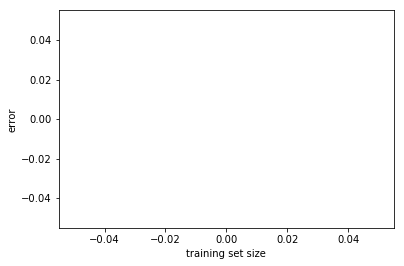

In [15]:
plt.plot(nb_sizes, nb_errs)
plt.xlabel('training set size')
plt.ylabel('error')

# (d)

In [16]:
import svm

ModuleNotFoundError: No module named 'svm'

In [ ]:
files = sorted(glob.glob('./spam_data/MATRIX.TRAIN.[0-9]*'), key=lambda s: int(s.rsplit('.')[-1]))

svm_sizes = []
svm_errs = []
mat_test, tok_test, cat_test = svm.readMatrix('./spam_data/MATRIX.TEST')
for f in files:
    mat, tok, cat = svm.readMatrix(f)
    svm_sizes.append(mat.shape[0])
    mod = svm.svm_train(mat, cat)
    output = svm.svm_test(mat_test, mod)
    svm_errs.append(svm.evaluate(output, cat_test))

In [ ]:
plt.plot(svm_sizes, svm_errs)
plt.xlabel('training set size')
plt.ylabel('error')

# (e)

In [ ]:
plt.plot(nb_sizes, nb_errs, label='navie bayes')
plt.plot(svm_sizes, svm_errs, label='svm')
plt.xlabel('training set size')
plt.ylabel('error')
plt.legend()

SVM outperforms NB at each training set size